In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

### Machine Learning Models

In [2]:
# Load the dataset
df = pd.read_csv("extracted_features_with_emotion.csv")

In [3]:
df.head()

,Participant_ID,Trial,FRONTAL_MEAN,FRONTAL_STD,FRONTAL_MAX_VALUE,FRONTAL_MIN_VALUE,FRONTAL_SKEWNESS,FRONTAL_KURTOSIS,FRONTAL_MEDIAN,FRONTAL_1st_DIFF_MEAN,...,OCCIPITAL_SKEWNESS_WAV_VALUE,OCCIPITAL_KURTOSIS_WAV_VALUE,OCCIPITAL_WAV_BAND,OCCIPITAL_ENTROPY_SPECTRAL,OCCIPITAL_ENTROPY_SHANNON,Valence,Arousal,Dominance,Liking,Emotion
0,s01,1,0.001359,4.004201,21.498158,-21.610319,-0.033265,1.157544,0.012683,0.000402,...,-0.240830,56.933169,3.757394,5.130237,2.161550,7.71,7.60,6.90,7.83,Happy/Excited
1,s01,2,0.012906,4.412052,21.076936,-22.273542,-0.027034,1.001990,0.019033,0.000275,...,-1.722563,41.971463,54.867696,5.013001,2.078751,8.10,7.31,7.28,8.47,Happy/Excited
2,s01,3,-0.004137,4.599285,36.928509,-33.003281,0.117162,5.242570,-0.005572,-0.000470,...,1.860689,93.708419,12.115209,5.038820,2.169897,8.58,7.54,9.00,7.08,Happy/Excited
3,s01,4,-0.027456,4.110787,21.748716,-24.528128,-0.022729,1.385224,-0.024023,0.000027,...,1.164910,57.342518,5.055052,4.989857,2.158516,4.94,6.01,6.12,8.06,Angry/Stressed
4,s01,5,-0.005914,3.581101,16.019129,-18.856439,-0.046923,0.542475,0.011176,-0.000091,...,-4.346694,75.514396,3.238226,5.154421,2.214743,6.96,3.92,7.19,6.05,Relaxed/Content


In [4]:
df.shape

(1280, 157)

In [5]:
# Drop non-feature columns
X = df.drop(columns=["Participant_ID", "Trial", "Emotion"])
y = df["Emotion"]

In [6]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Get participant IDs for group split
groups = df["Participant_ID"]

In [8]:
# Train-test split ensuring all trials of a participant remain in the same set
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_encoded, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

In [9]:
# Define models and hyperparameters
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Gradient Boosting": GradientBoostingClassifier()
}

param_grid = {
    "SVM": {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]},
    "Random Forest": {"classifier__n_estimators": [50, 100, 200]},
    "Decision Tree": {"classifier__max_depth": [None, 10, 20]},
    "XGBoost": {"classifier__n_estimators": [50, 100], "classifier__learning_rate": [0.01, 0.1]},
    "Gradient Boosting": {"classifier__n_estimators": [50, 100], "classifier__learning_rate": [0.01, 0.1]}
}

In [10]:
results = {}
# Iterate over models
for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("classifier", model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        "Best Params": grid_search.best_params_,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Classification Report": class_report
    }

In [11]:
# Convert results to DataFrame
metrics_df = pd.DataFrame({
    model: {
        "Accuracy": results[model]["Accuracy"],
        "Precision": results[model]["Precision"],
        "Recall": results[model]["Recall"],
        "F1-Score": results[model]["F1-Score"]
    }
    for model in results
}).T

In [12]:
# Print the final metrics DataFrame
print(metrics_df)


                   Accuracy  Precision    Recall  F1-Score
SVM                0.800000   0.797241  0.800000  0.797193
Random Forest      0.675000   0.674028  0.675000  0.670556
Decision Tree      0.496429   0.497024  0.496429  0.496517
XGBoost            0.696429   0.696549  0.696429  0.696470
Gradient Boosting  0.728571   0.729010  0.728571  0.728701


### Neural Network appraoch

In [13]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [14]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Define Neural Network class
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 2, len(np.unique(y_encoded)))
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [16]:
# Objective function for Optuna
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    
    model = NeuralNet(X_train.shape[1], hidden_size, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    model.train()
    for epoch in range(20):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(batch_y.numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [17]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-03-21 17:03:52,825] A new study created in memory with name: no-name-25e091c7-022b-4c09-930f-cf569a0c25a5
[I 2025-03-21 17:03:56,099] Trial 0 finished with value: 0.8392857142857143 and parameters: {'hidden_size': 149, 'dropout_rate': 0.3531013186711235, 'lr': 0.0008428039540741303, 'weight_decay': 0.00011572361269003041}. Best is trial 0 with value: 0.8392857142857143.
[I 2025-03-21 17:03:57,618] Trial 1 finished with value: 0.8357142857142857 and parameters: {'hidden_size': 97, 'dropout_rate': 0.3145723598113903, 'lr': 0.0004255000123232483, 'weight_decay': 0.00013202005280046585}. Best is trial 0 with value: 0.8392857142857143.
[I 2025-03-21 17:03:59,289] Trial 2 finished with value: 0.8107142857142857 and parameters: {'hidden_size': 201, 'dropout_rate': 0.1109593256157626, 'lr': 0.002851940628307876, 'weight_decay': 5.2468909799056947e-05}. Best is trial 0 with value: 0.8392857142857143.
[I 2025-03-21 17:04:00,807] Trial 3 finished with value: 0.8321428571428572 and paramet

In [18]:
# Train best model
best_params = study.best_params
best_model = NeuralNet(X_train.shape[1], best_params["hidden_size"], best_params["dropout_rate"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

best_model.train()
for epoch in range(20):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [19]:
# Evaluate best model
best_model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = best_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
class_report = classification_report(y_true, y_pred)

In [20]:
# Print results
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Classification Report:\n", class_report)

Best Hyperparameters: {'hidden_size': 54, 'dropout_rate': 0.49492280630022956, 'lr': 0.0037577064137385933, 'weight_decay': 1.3052846096816544e-05}
Accuracy: 0.85
Precision: 0.8495852129688602
Recall: 0.85
F1-Score: 0.8492405053865286
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        68
           1       0.90      0.89      0.89        90
           2       0.77      0.74      0.75        58
           3       0.85      0.81      0.83        64

    accuracy                           0.85       280
   macro avg       0.84      0.84      0.84       280
weighted avg       0.85      0.85      0.85       280



<Figure size 1200x600 with 0 Axes>

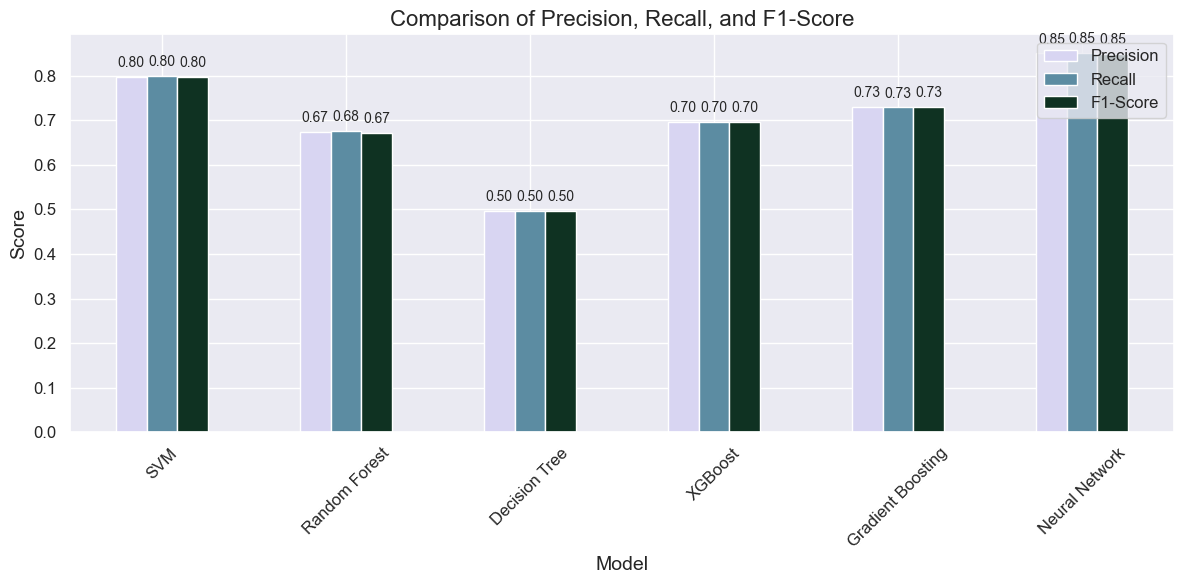

                   Accuracy  Precision    Recall  F1-Score
SVM                0.800000   0.797241  0.800000  0.797193
Random Forest      0.675000   0.674028  0.675000  0.670556
Decision Tree      0.496429   0.497024  0.496429  0.496517
XGBoost            0.696429   0.696549  0.696429  0.696470
Gradient Boosting  0.728571   0.729010  0.728571  0.728701
Neural Network     0.850000   0.849585  0.850000  0.849241


In [21]:
# Add the neural network's metrics to the metrics DataFrame
nn_metrics = {
    "Neural Network": {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
}

# Convert the neural network metrics to a DataFrame and concatenate with the existing metrics DataFrame
nn_metrics_df = pd.DataFrame(nn_metrics).T
combined_metrics_df = pd.concat([metrics_df, nn_metrics_df])

# Generate the cubehelix palette with start=2
cubehelix_palette = sns.cubehelix_palette(start=2, n_colors=3)

# Plot the comparison of precision, recall, and F1-score
plt.figure(figsize=(12, 6))
ax = combined_metrics_df[["Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(12, 6), color=cubehelix_palette)
plt.title("Comparison of Precision, Recall, and F1-Score", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right", fontsize=12)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # Format the number to 2 decimal places
        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position of the label
        ha="center",  # Horizontal alignment
        va="center",  # Vertical alignment
        xytext=(0, 10),  # Offset from the bar
        textcoords="offset points",  # Coordinate system for the offset
        fontsize=10,  # Font size of the label
    )

plt.tight_layout()
plt.show()

# Print the combined metrics DataFrame
print(combined_metrics_df)